# How to post good questions on Stack Overflow?

### Making Stack Overflow less intimidating for new programmers.

 We all know that Stack Overflow can be an extremely toxic place for new programmers. When new programmers ask questions on the platform, they get trolled and receive unhelpful answers if the community interprets the post as a 'bad' question. This discourages new coders from learning and raises the entry bar to programming.

We decided to build a Machine Learning model to classify a question as a good question to be posted or not. This model can serve as a great foundation for more advanced applications like giving recommendations to programmers to ask better questions so that they are less likely to have a bad experience and more importantly they get their questions answered without receiving unnecessary trolling and negativity. 

In this project, we will be using Logistic Regression to predict whether a question asked on the well known Stack Overflow platform will receive positive or negative votes.

In [ ]:
# Start writing code here...
import pandas as pd
import numpy as np
from datascience import*
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

from sklearn import neighbors, datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Data Collection and Cleaning

We took a dataset about analytics of questions and comments posted on Stack Overflow. The table below is the original dataset which only excludes the 'ID' columns, the unique ID to idenfity each unique post, because we will not be needing it in our data analysis

In [ ]:
#Importing the data
dat = pd.read_csv('Questions.csv')
dat = dat.drop(columns=['Id', 'OwnerUserId'])
dat.head()

,CreationDate,Score,Title,Body
0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


The dataset is incredibly large and consists of hundreds of thousands of rows which represent unique posts on stack overflow

In [ ]:
print(f'Rows in dataset: {len(dat)}')

Rows in dataset: 607282


We produced a histogram showing frequency of number of likes that questions posted on stack overflow recieve. Vast majority of posts get a score between -100 and 100. The dataset however, is so large and the range of scores is so vast that a histogram of the raw data does not give us a good visual of what is going on. 

### Histogram of points of StackOverflow Posts

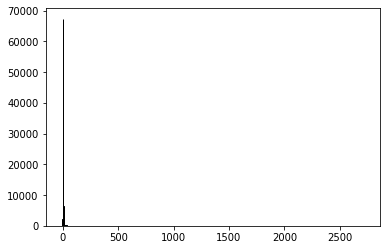

In [ ]:
plt.hist(dat.sample(100000)['Score'], bins=1000)
plt.show()

To get a better look at the distribution, we produced another histogram where the score of each post is constrained to less than 100. Since most of the data have a score of less than a 100, this gives us a better look at how the data is distributed. 

### Zoomed in Histogram of points of StackOverflow Posts

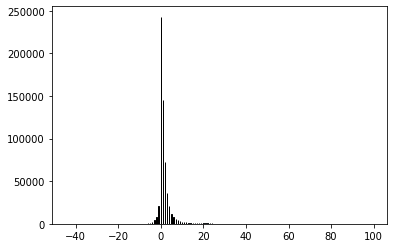

In [ ]:
plt.hist(dat.loc[dat['Score'] <100].sample(607282, replace = True)['Score'], bins=1000)
plt.show()

We found that the dataset had a heavy bias towards posts with positive upvotes as opposed to posts with negative upvotes. Positive upvotes meaning posts with more upvotes than downvotes and negative upvotes meaning more downvotes than upvotes. 

The dataset refers to the integer of upvotes/downvotes as 'scores' so we will use that language.

In [ ]:
print(f"There are {len(dat[dat['Score'] > 0].index)} posts with positive score")
print(f"There are {len(dat[dat['Score'] < 0].index)} posts with negative score")

There are 327688 posts with positive points
There are 36310 posts with negative points


We took a random sample of 45000 posts with positive scores to use in our data set to make the data more balanced with points with negative scores. The next few tables are the sampled positive posts, a table of the negative post and the new table which resulted from joining both the sampled positive posts and all the negative posts. This resulting table is the new working dataset we use for our predicitive model. 

### Table of sampled posts with positive points

In [ ]:
#Sampling 45000 +ve rated questions and storing positive rated questions in 'positive' table.
positive = dat[dat['Score'] > 0]
positive.sample(frac=1)
positive = positive[:45000]
positive.head()

,CreationDate,Score,Title,Body
0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


### Table of posts with negative points

In [ ]:
#Storing all negative rated questions in 'negative' table.
negative = dat[dat['Score'] < 0]
negative.head()

,CreationDate,Score,Title,Body
803,2008-10-14T08:25:09Z,-1,fast filter method in python,<p>I want to filter two list with any fastest ...
1105,2008-11-03T17:09:05Z,-1,python smtplib,<p>Hey I have a windows server running python ...
1740,2008-12-16T12:27:53Z,-3,String conversion in Python,<p>I'm using Python 2.5. The DLL I imported is...
1764,2008-12-17T13:47:51Z,-1,need help-variable creation in Python,<p>I want to create variables as <code>a1</cod...
1777,2008-12-18T05:43:39Z,-3,need help-variable creation in Python (continu...,"<p><a href=""http://stackoverflow.com/questions..."


'result' is the new working dataset with the sampled positive posts and all of the negative posts

### Joined table of sampled positive posts and negative posts

In [ ]:
#Joining the positive and negative tables in a new table 'result'. Now this new dataset has a good balance of positive and negative rated questions.
frames = [positive, negative]
result = pd.concat(frames)
# Removing Creation Date column as it is not in a format that can be used in the model. 
result = result.drop(columns=['CreationDate'])
result.head()

,Score,Title,Body
0,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


In [ ]:
print(f'Number of rows: {len(result)}')

Number of rows: 81310


### Histogram of new Dataset

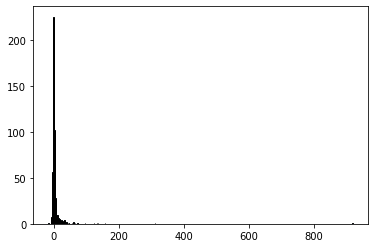

In [ ]:
plt.hist(result.sample(1000)['Score'], bins=1000)
plt.show()

## Deciding Features

Deciding which features to use is a key component of the entire project. Our Machine Learning model will use features (also known as attributes) to decide whether a question is expected to receive a net positive or a net negative score on Stack Overflow.

Every stack overflow question has a Title (a short summary of the question) and the Body (the question with any necessary descriptions). 

Let's start by adding two features, the number of words in the Title and the number of words in the Body of the question. The word_counter function helps us to count the number of words in a given string. 

In [ ]:
#Deciding features (attributes) for the model begins here. 
#In the next two cells we are adding two features: Number of words in title and Number of words in body.
from collections import Counter

#word counting function


def word_counter(sentence):
    word_count = len(sentence.split())
    return word_count

#Trial
word_counter('This project is hard!')

4

In [ ]:
#title_length is an array which contains the number of words in each entry of the 'Title' column of the result table
#body_length is an array which contains the number of words in each entry of the 'Title' column of the result table

title_length = result['Title'].apply(lambda x: word_counter(x))
body_length = result['Body'].apply(lambda x: word_counter(x))
result['Word length title'] = title_length.tolist()
result['Word length body'] = body_length.tolist()
result.head()

,Score,Title,Body,Word length title,Word length body
0,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,17,77
1,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,9,38
2,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,7,103
3,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,9,16
4,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,12,47


Stop words are a set of commonly used words in a language. Examples of stop words in English are “a”, “the”, “is”, “are” and etc. Stop words are commonly used in Text Mining and Natural Language Processing (NLP) to eliminate words that are so commonly used that they carry very little useful information.

We will be adding two more features: Stop words in the Title and Stop words in the Body. The function stop_word_counter counts the number of stop words in a given string.

In [ ]:
from gensim.parsing.preprocessing import remove_stopwords
# In the next two cells, we are adding two features. Number of stop words in the title and body respectively.

#Function which counts the number of stop words in a string
def stop_word_counter(text):
    filtered_sentence = remove_stopwords(text) 
    filtered_sentence_length = word_counter(filtered_sentence)
    stop_word_count = word_counter(text) - filtered_sentence_length
    return stop_word_count


stop_word_counter("Nick likes to play football, however he is not too fond of tennis.")


7

In [ ]:
#Adding the number of stop words in body and title of the stack overflow question as columns of the table.
title_stop_length = result['Title'].apply(lambda x: stop_word_counter(x))
body_stop_length = result['Body'].apply(lambda x: stop_word_counter(x))
result['Stop Word length title'] = title_stop_length.tolist()
result['Stop Word length body'] = body_stop_length.tolist()
result.head()

,Score,Title,Body,Word length title,Word length body,Stop Word length title,Stop Word length body
0,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,17,77,11,33
1,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,9,38,4,17
2,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,7,103,2,49
3,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,9,16,3,8
4,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,12,47,5,21


Another set of features which may be helpful is proportion of stopwords. A question may have a large proportion of stopwords and hence might be difficult to understand. So we will be adding two more features, proportion of stopwords in the Title and Body respectively.

Let's also consider the number of characters in the Title and Body respectively as features for our model.

In [ ]:
#Adding four more features, proportion of stop words in body, proportion of stop words in title, number of characters in body and title
title_stop_prop = result['Title'].apply(lambda x: (stop_word_counter(x)/word_counter(x))*100)
body_stop_prop = result['Body'].apply(lambda x: (stop_word_counter(x)/word_counter(x))*100)
title_len = result['Title'].apply(lambda x: len(x))
body_len = result['Body'].apply(lambda x: len(x))
result['Stop Word proportion (title)'] = title_stop_prop.tolist()
result['Stop Word proportion (body)'] = body_stop_prop.tolist()
result['No. of characters (title)'] = title_len.tolist()
result['No. of characters (body)'] = body_len.tolist()
result.head()

,Score,Title,Body,Word length title,Word length body,Stop Word length title,Stop Word length body,Stop Word proportion (title),Stop Word proportion (body),No. of characters (title),No. of characters (body)
0,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,17,77,11,33,64.705882,42.857143,70,445
1,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,9,38,4,17,44.444444,44.736842,39,314
2,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,7,103,2,49,28.571429,47.572816,51,624
3,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,9,16,3,8,33.333333,50.000000,46,91
4,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,12,47,5,21,41.666667,44.680851,62,317


This is the final set of features: The number of sentences in the Title and Body respectively.

In [ ]:
#Adding two more features, number of sentences in body and title each
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

title_sentlen = result['Title'].apply(lambda x: len(sent_tokenize(x)))
body_sentlen = result['Body'].apply(lambda x: len(sent_tokenize(x)))
result['No. of sentences (title)'] = title_sentlen.tolist()
result['No. of sentences (body)'] = body_sentlen.tolist()

result.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Score,Title,Body,Word length title,Word length body,Stop Word length title,Stop Word length body,Stop Word proportion (title),Stop Word proportion (body),No. of characters (title),No. of characters (body),No. of sentences (title),No. of sentences (body)
0,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,17,77,11,33,64.705882,42.857143,70,445,1,1
1,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,9,38,4,17,44.444444,44.736842,39,314,1,2
2,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,7,103,2,49,28.571429,47.572816,51,624,1,3
3,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,9,16,3,8,33.333333,50.000000,46,91,1,2
4,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,12,47,5,21,41.666667,44.680851,62,317,1,1


Since we want to classify questions into positively rated and negatively rated and not predict their score, we added a categorical column to our table called 'Scores_classified' where 1 refers to a question that has postive votes while -1 refers to a question that has negative votes. Our Machine Learning model will be classifying questions into these two categories.

In [ ]:
#Converting the score column into a binary format with scores>=0 as 1 and scores<0 as -1 so that we can use a binary classification model.
def convert_to_0and1(num):
    if num>=-0:
        return 1
    else:
        return -1

Scoreclassify = result['Score'].apply(lambda x: convert_to_0and1(x))
result['Scores_classified'] = Scoreclassify.tolist()
result.head()

,Score,Title,Body,Word length title,Word length body,Stop Word length title,Stop Word length body,Stop Word proportion (title),Stop Word proportion (body),No. of characters (title),No. of characters (body),No. of sentences (title),No. of sentences (body),Scores_classified
0,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,17,77,11,33,64.705882,42.857143,70,445,1,1,1
1,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,9,38,4,17,44.444444,44.736842,39,314,1,2,1
2,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,7,103,2,49,28.571429,47.572816,51,624,1,3,1
3,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,9,16,3,8,33.333333,50.000000,46,91,1,2,1
4,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,12,47,5,21,41.666667,44.680851,62,317,1,1,1


## Visualizations

Before constructing and training our model, we must visualize our data to get a sense of what distribution of data we are working with. Further, our visualizations can help us identify which features we would like to use in our model, what associations do they have with their scores, corrupt data, and outliers, hence indicating further data cleaning. Below we have multiple different data plots, which help us gain a well rounded understanding of our data and most importantly, tells us how their scores are related to the various features defined previously. 

Plot of Word Length of Title vs. Score

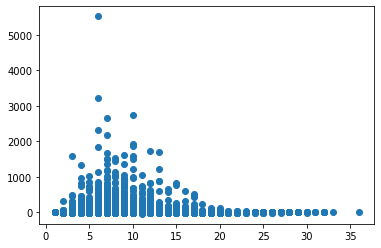

In [ ]:
#Visualizations begin here. 
plt.scatter(result['Word length title'], result['Score'])

Plot of Word Length of Body vs. Score

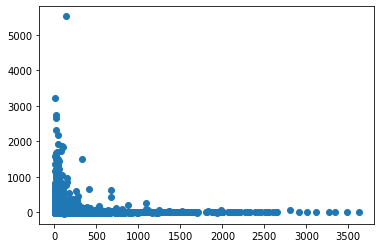

In [ ]:
plt.scatter(result['Word length body'], result['Score'])

Plot of Stop Word Length of Title vs. Score

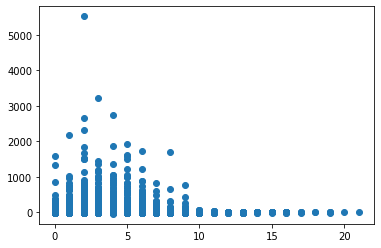

In [ ]:
plt.scatter(result['Stop Word length title'], result['Score'])

Plot of Stop Word Length of Body vs. Score

Notice the couple outlier in this dataset - these are important to take note of and would not have been noticed had it not been for data visualization!

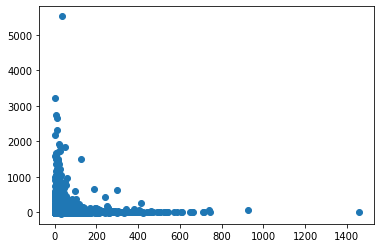

In [ ]:
plt.scatter(result['Stop Word length body'], result['Score'])

Plot of Stop Word Proportion in Body vs. Score

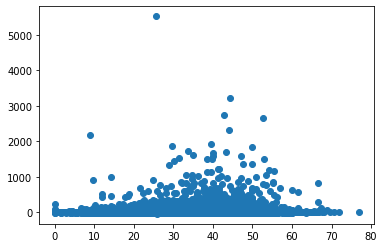

In [ ]:
plt.scatter(result['Stop Word proportion (body)'], result['Score'])

Plot of Stop Word Proportion in Title vs. Score

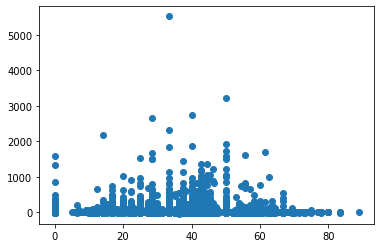

In [ ]:
plt.scatter(result['Stop Word proportion (title)'], result['Score'])

Plot of the Number of Characters in Title vs. Score

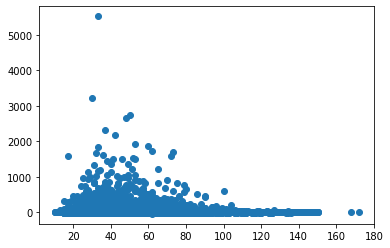

In [ ]:
plt.scatter(result['No. of characters (title)'], result['Score'])

Plot of the Number of Characters in Body vs. Score

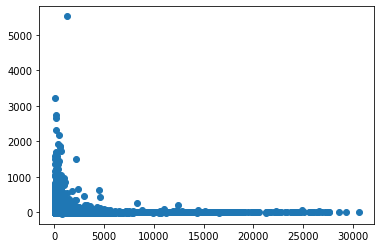

In [ ]:
plt.scatter(result['No. of characters (body)'], result['Score'])

Plot of the Number of Sentences in Title vs. Score

Notice the couple outliers in this dataset - these are important to take note of and would not have been noticed had it not been for data visualization!

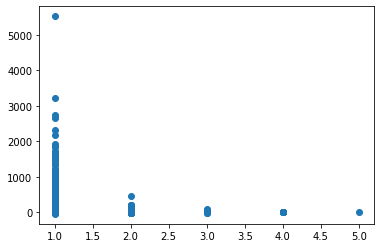

In [ ]:
plt.scatter(result['No. of sentences (title)'], result['Score'])

Plot of the Number of Sentences in Body vs. Score

Notice the couple outliers in this dataset - these are important to take note of and would not have been noticed had it not been for data visualization!

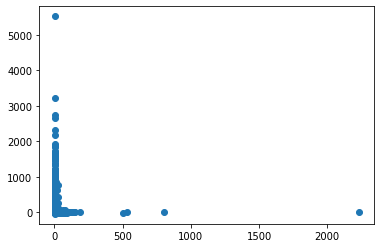

In [ ]:
plt.scatter(result['No. of sentences (body)'], result['Score'])

Given the nature of the dataset, we decided not to remove the outliers from our data as they did not pose massive changes to the performance of the model. 

## Machine Learning

We are using logistic regression to use the various features of stackoverflow questions we defined above and predict whether a question received a net positive  or net negative score.

Checking the first few rows of the test data to make sure that all the attributes and data are in place.

In [ ]:
#Machine Learning begins here
#Splitting our dataset into training and testing set. Ratio: 70:30
training_data, test_data = train_test_split(result, test_size=0.3, random_state=2)
training_data.head()

,Score,Title,Body,Word length title,Word length body,Stop Word length title,Stop Word length body,Stop Word proportion (title),Stop Word proportion (body),No. of characters (title),No. of characters (body),No. of sentences (title),No. of sentences (body),Scores_classified
29216,1,"python: what is this funny notation? [0,1,3]._...",<ol>\n<li>why would anyone use double undersco...,7,22,3,8,42.857143,36.363636,54,204,2,1,1
16511,1,pydoc fails under Windows and Python 2.6.4,<p>When trying to use pydoc under Windows and ...,7,61,2,10,28.571429,16.393443,42,477,1,2,1
405695,-4,print sep='' not working in Python 2.7.8,"<p>As a trial, I used the following code in Py...",7,38,2,6,28.571429,15.789474,40,306,1,1,-1
596736,-1,Getting for line in plaintext.split('\n'): Uni...,<p>I'm going to design sentimental analysis on...,19,367,5,43,26.315789,11.716621,140,4930,1,1,-1
348592,-2,Using raw input inside of a class (python 2.7),<p>I was wondering how to use raw input inside...,9,73,2,22,22.222222,30.136986,46,535,1,2,-1


Checking the first few rows of the test data to make sure that all the attributes and data are in place.

In [ ]:
test_data.head()

,Score,Title,Body,Word length title,Word length body,Stop Word length title,Stop Word length body,Stop Word proportion (title),Stop Word proportion (body),No. of characters (title),No. of characters (body),No. of sentences (title),No. of sentences (body),Scores_classified
13010,18,the best shortest path algorithm,<p>what is the difference between the <strong>...,5,91,1,27,20.000000,29.670330,34,638,1,1,1
10077,1,Python: Running command line application to th...,<p>I want to try to use a command line script ...,12,121,3,43,25.000000,35.537190,83,877,2,4,1
22719,2,Is there a method to find out if a package is ...,<p>I can look inside setup.py I suppose to see...,19,78,12,36,63.157895,46.153846,99,438,1,4,1
598470,-2,"Sorting by value and printing both, key and va...",<p><strong>Question 1</strong>: How Can I add ...,11,382,3,93,27.272727,24.345550,66,2822,2,34,-1
413056,-2,Having Trouble Installing iPython,"<p>Well, my python was working perfectly. All...",4,358,0,82,0.000000,22.905028,33,3424,1,6,-1


In [ ]:
# Training and testing 
X_train = training_data.drop(columns='Score').drop(columns='Scores_classified').drop(columns='Title').drop(columns='Body')[['Word length title','Word length body','Stop Word length title','Stop Word length body','Stop Word proportion (title)', 'Stop Word proportion (body)', 'No. of characters (title)', 'No. of sentences (title)', 'No. of sentences (body)']]
y_train = training_data['Scores_classified']

X_test = test_data.drop(columns='Score').drop(columns='Scores_classified').drop(columns='Title').drop(columns='Body')[['Word length title','Word length body','Stop Word length title','Stop Word length body','Stop Word proportion (title)', 'Stop Word proportion (body)', 'No. of characters (title)', 'No. of sentences (title)', 'No. of sentences (body)']]
y_test = test_data['Scores_classified']

We will be using Logistic Regression for our classification.

In [ ]:
#Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

We have a moderately high rate of success, which means that any stackoverflow question put through our model will have a better than random chance to classify a question correctly.

In [ ]:
#Printing the accuracy of our model
y_predicted_logistic = logistic_model.predict(X_test)
accuracy = metrics.accuracy_score(y_predicted_logistic,y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 62.100%


Afterthought: Increasingly, Stackoverflow has been on of the most toxic QnA coding sites on the internet. Whereas sites such as quora is lenient towards newbie questions, Stackoverflow fails to educate its users on how to ask "quality questions" and continues allowing verbal abuse towards its users and marginalization of minority groups. This not only creates a online culture of discriminiation but also can discourage new coders and coders from marginalized groups from entering the industry, continuing a cycle of systemic racism. Just as a good answer can help coders get unstuck, a harsh comment can make them give up completely.

Imrovements we could have made in the project:

Obviously,our presentation is not perfect. There are multiple ways in which we could have improved our project. Notably, we could have added another attribute like a grammar evaluation score for each question. Something else we could consider is to check how generic the questions. If questions have been repeatedly asked before it would tend to have a lower sccore and is more likely to be trolled. Incorporating these attributes would improve our modest 62% accuracy to something higher!

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1e4041b9-cc41-4429-9e6b-3601bf39e8e4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>